# Numbers Summation (using RNN LSTM)

##### Name: Marcel Zama   
##### Student Nr: C00260146
##### Date: 12/04/2024

## Experiment overview

In this experiment we will use Recurrent Neural Network (RNN) to sum up two numbers (each number is in a range of `[1, 99]`). The summation expression (i.e. `"1+45"` or `37+68`) that will be sent to the RNN _input_ will be treated as a **string** (sequence of characters) and the _output_ of the RNN will also be a string (i.e. `"46"` or `"106"`) - the sequence of characters that will represent the result of summation. This is a "sequence-to-sequence" version of RNN implementation. We will use LSTM (Long Short-Term Memory) recurent neural network for this task.

For this experiment we will use Tensorflow v2 with its Keras API.

## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math
import datetime

## Configuring Tensorboard

We will use [Tensorboard](https://www.tensorflow.org/tensorboard) to debug the model later.

In [3]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

## Generate a dataset

In order to train a neural network we need to generate a training dataset which will consist of examples `x` (set of summation expressions) and labels `y` (set of correct answers for each expression). We will start with generating a set of _numbers_ (not strings so far) and than we will convert the sets of numbers into _strings_.

In [4]:
dataset_size = 5000
sequence_length = 2
max_num = 100

In [5]:
# Generates summation sequences and summation results in form of vector if numbers.
def generate_sums(dataset_size, sequence_length, max_num):
    # Initial dataset states.
    x, y = [], []
    
    # Generating sums.
    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [6]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:3])
print()
print('y_train:\n', y_train[:3])

x_train:
 [[36, 86], [62, 86], [70, 43]]

y_train:
 [122, 148, 113]


Recurrent neural networks are normally deals with the sequences (of one or many elements) on the input. In order to treat a summation expression as a sequence we will convert array of numbers (i.e. `[[13, 8], [85, 91], ...]`) into strings (i.e. `['13+8   ', '85+91  ', ...]`). We also want to add a space `" "` paddings to each string to make them all of the same length. After doing that we will be able to feed our RNN character by character (i.e. `1`, then `3`, then `+`, then `8`, then ` ` and so on).

In [7]:
# Convert array of numbers for x and y into strings.
# Also it adds a space (" ") padding to strings to make them of the same length. 
def dataset_to_strings(x, y, max_num):
    # Initial dataset states.
    x_str, y_str = [], []
    
    sequnce_length = len(x[0])
    
    # Calculate the maximum length of equation (x) string (i.e. of "11+99")
    num_of_pluses = sequnce_length - 1
    num_of_chars_per_digit = math.ceil(math.log10(max_num + 1))
    max_x_length = sequnce_length * num_of_chars_per_digit + num_of_pluses
    
    # Calculate the maximum length of label (y) string (i.e. of "167")
    max_y_length = math.ceil(math.log10(sequnce_length * (max_num + 1)))
    
    # Add a space " " padding to equation strings to make them of the same length.
    for example in x:
        str_example = '+'.join([str(digit) for digit in example])
        str_example += ''.join([' ' for padding in range(max_x_length - len(str_example))])
        x_str.append(str_example)
    
    # Add a space " " padding to labels strings to make them of the same length.
    for label in y:
        str_example = str(label)
        str_example += ''.join([' ' for padding in range(max_y_length - len(str_example))])
        y_str.append(str_example)
    
    return x_str, y_str

In [8]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['36+86  ' '62+86  ' '70+43  ']

y_train_str:
 ['122' '148' '113']


In [9]:
# Since we allow only numbers, plus sign and spaces the vocabulary looks pretty simple.
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [10]:
# Python dictionary that will convert a character to its index in the vocabulary.
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


Our RNN need to have a digits as an input to operate with (and not a strings). To convert summation expressions strings into number the first step we will do is to convert each character of each string into the position index of this character in the `vocabulary`.

In [11]:
# Converts x and y arrays of strings into array of char indices.
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [12]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[ 3  6 10  8  6 11 11]
 [ 6  2 10  8  6 11 11]
 [ 7  0 10  4  3 11 11]]

y_train_encoded:
 [[1 2 2]
 [1 4 8]
 [1 1 3]]


To make our dataset even more understandable for our recurrent neural network we will convert each number into `0/1` [one-hot vector](https://en.wikipedia.org/wiki/One-hot) (i.e. number `1` will be transformed into array `[0 1 0 0 0 0 0 0 0 0 0 0]`).

In [13]:
# Convert x and y sets of numbers into one-hot vectors.
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [14]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_train_one_hot:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]]]


Now we may combine all the function together and create a one function that will do all the work to generate a dataset in the proper format for us.

In [15]:
# Generates a dataset.
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    # Generate integet sum sequences.
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    # Convert integer sum sequences into strings.
    x, y = dataset_to_strings(x, y, max_num)
    # Encode each character to a char indices.
    x, y = dataset_to_indices(x, y, vocabulary)
    # Encode each index into one-hot vector.
    x, y = dataset_to_one_hot(x, y, vocabulary)
    # Return the data.
    return np.array(x), np.array(y)

In [16]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]]]


In [17]:
print('x.shape: ', x.shape) # (input_sequences_num, input_sequence_length, supported_symbols_num)
print('y.shape: ', y.shape) # (output_sequences_num, output_sequence_length, supported_symbols_num)

x.shape:  (5000, 7, 12)
y.shape:  (5000, 3, 12)


In [18]:
# How many characters each summation expression has.
input_sequence_length = x.shape[1]

# How many characters the output sequence of the RNN has.
output_sequence_length = y.shape[1]

# The length of one-hot vector for each character in the input (should be the same as vocabulary_size).
supported_symbols_num = x.shape[2]

# The number of different characters our RNN network could work with (i.e. it understands only digits, "+" and " ").
vocabulary_size = len(vocabulary)

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)
print('vocabulary_size: ', vocabulary_size)

input_sequence_length:  7
output_sequence_length:  3
supported_symbols_num:  12
vocabulary_size:  12


In [19]:
# Converts a sequence (array) of one-hot encoded vectors back into the string based on the provided vocabulary.
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [20]:
decode(y[0], vocabulary)

'156'

## Build a model

We will use a [Sequential] TensorFlow model with [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers. Logically our model will consist of **encoder** and **decoder**. _Encoder_ will encode the input expression into an array of numbers. And then _decoder_ will try to build an output result sequence by decoding the array of numbers from encoder.

In [21]:
epochs_num = 200
batch_size = 128

In [22]:
model = tf.keras.models.Sequential()

# Encoder
# -------

model.add(tf.keras.layers.LSTM(
    units=128,
    input_shape=(input_sequence_length, vocabulary_size),
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

# Decoder
# -------

# We need this layer to match the encoder output shape with decoder input shape.
# Encoder outputs ONE vector of numbers but for decoder we need have output_sequence_length vectors.
model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=128,
    return_sequences=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=vocabulary_size,
    )
))

model.add(tf.keras.layers.Activation(
    activation='softmax'
))

C:\Users\marci\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 12)          │         1,548 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3, 12)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,324 (802.05 KB)

 Trainable params: 205,324 (802.05 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Train a model

In [25]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'],
)

In [27]:
history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2192 - loss: 2.3926 - val_accuracy: 0.3740 - val_loss: 2.1018
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3820 - loss: 1.9850 - val_accuracy: 0.3807 - val_loss: 1.8777
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3778 - loss: 1.8327 - val_accuracy: 0.3800 - val_loss: 1.7842
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3863 - loss: 1.7615 - val_accuracy: 0.3947 - val_loss: 1.7422
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3983 - loss: 1.7132 - val_accuracy: 0.4007 - val_loss: 1.6949
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4075 - loss: 1.6956 - val_accuracy: 0.4020 - val_loss: 1.6882
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4101 - loss: 1.6611 - val_accuracy: 0.4020 - val_loss: 1.6534
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4072 - loss: 1.6517 - val_accuracy: 0.4120 -

In [28]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

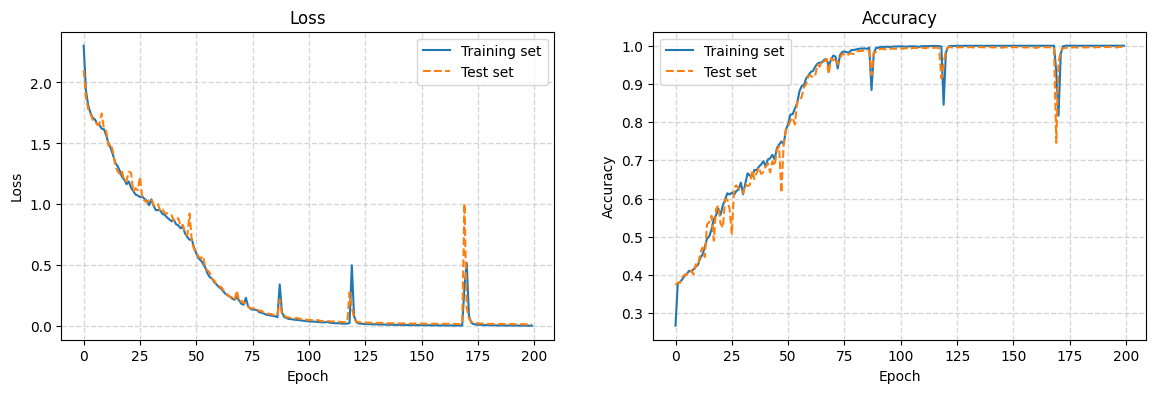

In [29]:
render_training_history(history)

## Test a dataset

In [30]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_test:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]]]


In [31]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
predictions.shape:  (5000, 3, 12)

predictions[0]:
 [[2.54616380e-12 9.99994993e-01 3.88131584e-13 5.02288717e-15
  9.84769398e-16 2.04166651e-16 1.78914937e-15 1.31587219e-13
  3.67059924e-11 4.97570545e-06 1.36009122e-14 3.52711666e-17]
 [3.92778369e-04 9.96764302e-01 2.83755339e-03 5.06556489e-06
  4.97594606e-08 9.42282710e-11 3.45078632e-10 3.33670425e-09
  2.89705131e-08 6.66006343e-08 6.88887974e-11 1.45105854e-11]
 [1.31662176e-07 3.77960646e-06 5.86138573e-03 9.91693556e-01
  2.44049774e-03 2.00625138e-07 5.00832797e-09 2.11997975e-09
  1.02824407e-08 2.29043118e-09 9.01115571e-11 3.99144852e-07]]

predictions[1]:
 [[2.2949932e-12 9.9999595e-01 1.0624053e-11 2.0432717e-14 1.3090113e-14
  4.2717934e-15 2.2565032e-14 2.9877481e-12 8.5999166e-11 4.0200680e-06
  9.1338111e-14 8.1182543e-17]
 [9.8395340e-06 3.5355631e-03 9.9580884e-01 6.4284872e-04 1.3416501e-06
  2.4933018e-07 3.0820311e-07 9.8176508e-07 1.7370704e-08 1.6958056e-08
  2.5360

In [32]:
x_encoded = [decode(example, vocabulary) for example in x_test]
y_expected = [decode(label, vocabulary) for label in y_test]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 40
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

52+61   = 113 [predict: 113] ✓
99+27   = 126 [predict: 126] ✓
3+74    = 77  [predict: 77 ] ✓
5+9     = 14  [predict: 14 ] ✓
4+92    = 96  [predict: 96 ] ✓
14+51   = 65  [predict: 65 ] ✓
9+65    = 74  [predict: 74 ] ✓
21+74   = 95  [predict: 95 ] ✓
5+94    = 99  [predict: 99 ] ✓
3+91    = 94  [predict: 94 ] ✓
22+55   = 77  [predict: 77 ] ✓
36+25   = 61  [predict: 61 ] ✓
25+46   = 71  [predict: 71 ] ✓
20+3    = 23  [predict: 23 ] ✓
80+52   = 132 [predict: 132] ✓
84+36   = 120 [predict: 120] ✓
44+58   = 102 [predict: 102] ✓
7+12    = 19  [predict: 19 ] ✓
50+39   = 89  [predict: 89 ] ✓
47+38   = 85  [predict: 85 ] ✓
27+5    = 32  [predict: 32 ] ✓
40+97   = 137 [predict: 137] ✓
46+55   = 101 [predict: 101] ✓
74+66   = 140 [predict: 140] ✓
40+78   = 118 [predict: 118] ✓
32+100  = 132 [predict: 132] ✓
16+51   = 67  [predict: 67 ] ✓
72+21   = 93  [predict: 93 ] ✓
21+54   = 75  [predict: 75 ] ✓
87+56   = 143 [predict: 143] ✓
60+42   = 102 [predict: 102] ✓
96+66   = 162 [predict: 162] ✓
21+50   

## Debugging the model with TensorBoard

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

In [33]:
%tensorboard --logdir .logs/fit

Reusing TensorBoard on port 6006 (pid 22176), started 1 day, 4:49:20 ago. (Use '!kill 22176' to kill it.)

## Save a model

In [34]:
model_name = 'numbers_summation_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/numbers_summation_rnn/numbers_summation_rnn.h5 \
  ./demos/public/models/numbers_summation_rnn
```

You may find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.